In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [52]:
import sys

d = '/Users/wfarr/Code/pydelfi'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)

import h5py
    
from pydelfi import delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf

import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [96]:
dls = array([ 1.23766646,  3.71299937,  6.18833228,  8.66366519, 11.1389981 ,
       13.61433102])
sigmas = array([0.30114003, 0.40301369, 0.76958809, 1.82501409, 3.80806915,
       8.68298521])

m90_0 = 52.0

def simulator(theta, seed=None, simulator_args=None, batch=None):
    if seed is not None:
        np.random.seed(seed)
        
    h0, Om, w, m90 = theta
    #h0 = Planck15.H0.to(u.km/u.s/u.Mpc).value
    #Om = Planck15.Om0
    #w = theta[0]
    #m90 = m90_0
    
    
    c = cosmo.FlatwCDM(h0*u.km/u.s/u.Mpc, Om, w)
        
    zs = array([cosmo.z_at_value(c.luminosity_distance, d*u.Gpc) for d in dls])
    
    return m90*(1+zs) + sigmas*randn(len(dls))

In [97]:
theta_fiducial = array([Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1.0, m90_0])
#theta_fiducial = array([-1.0])

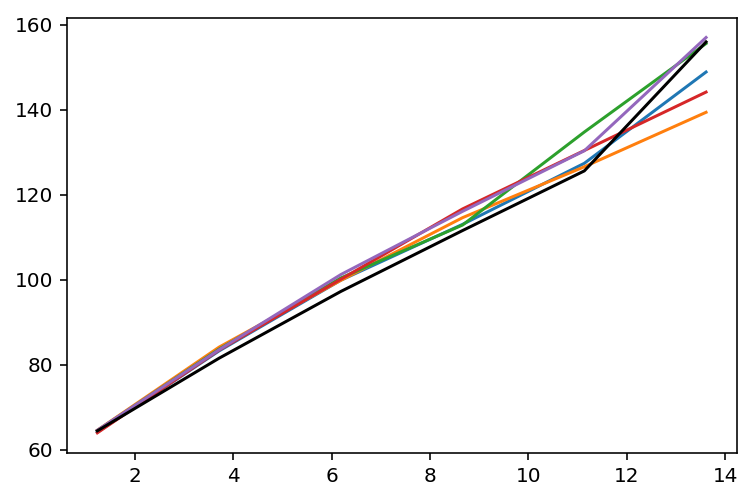

In [100]:
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))
plot(dls, simulator(theta_fiducial))

plot(dls, simulator(theta_fiducial + array([0.0, 0, -0.5, 0.0])), '-k')

In [107]:
prior_low = array([35.0, 0.0, -2.0, 30.0])
prior_high = array([140.0, 0.75, 0.0, 85.0])

# Use these priors if you just want to measure w:
#prior_C = np.diag([(0.01*theta_fiducial[0])**2, (0.01*theta_fiducial[1])**2, 0.5**2, 10.0**2])

# Use these priors if you don't want to measure w, but want to just constrain cosmology:
prior_C = np.diag([15**2, 0.15**2, 0.5**2, 10.0**2])

prior = priors.TruncatedGaussian(theta_fiducial, prior_C, prior_low, prior_high)

In [108]:
compressor = score.Gaussian(len(simulator(theta_fiducial)), theta_fiducial, prior_mean=theta_fiducial, prior_covariance=prior_C)

In [109]:
compressor.compute_mean_covariance(simulator, 250)
compressor.compute_derivatives(simulator, 250, abs(0.01*theta_fiducial))

In [110]:
compressor.compute_fisher()

In [111]:
sqrt(diag(compressor.Finv))

array([9.04048045, 0.10959674, 0.43867693, 0.94674841])

In [55]:
with h5py.File('observations.h5', 'r') as f:
    m1det = array(f['posteriors/m1det'])
    dldet = array(f['posteriors/dl'])

In [66]:
dlbins = linspace(0, np.max(dldet), 13)

m90s = []

for j in range(dldet.shape[1]):
    d = dldet[:,j]
    m = m1det[:,j]
    
    m9 = []
    for l,h in zip(dlbins[:-1], dlbins[1:]):
        s = (l <= d) & (d < h)
        if count_nonzero(s) > 0:
            m9.append(percentile(m[s], 90))
        else:
            m9.append(0)
    
    m90s.append(m9)
m90s = array(m90s)

In [67]:
m90s.shape

(4000, 12)

In [72]:
for i in range(m90s.shape[1]):
    print(i, np.any(m90s[:,i]==0))

0 False
1 False
2 False
3 False
4 False
5 False
6 True
7 True
8 True
9 True
10 True
11 True


<ErrorbarContainer object of 3 artists>

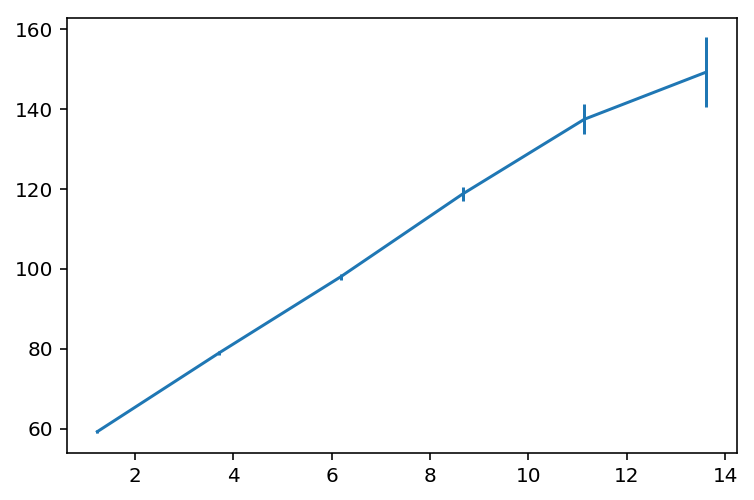

In [74]:
errorbar(0.5*(dlbins[1:]+dlbins[:-1])[:6], mean(m90s, axis=0)[:6], std(m90s, axis=0)[:6])

In [76]:
0.5*(dlbins[1:] + dlbins[:-1])[:6]

array([ 1.23766646,  3.71299937,  6.18833228,  8.66366519, 11.1389981 ,
       13.61433102])

In [75]:
std(m90s, axis=0)[:6]

array([0.30114003, 0.40301369, 0.76958809, 1.82501409, 3.80806915,
       8.68298521])